# Random Forest - Heart Disease Classification
Part 2 of the course project in *Artificial intelligence applied to engineering* at ETSEIB, UPC, spring 2024. The team members contributing to the deliverable is 
- Lise Jakobsen
- Julie Sørlie Lund
- Magnus Ingnes Sagmo

The dataset used in this deliverable can be retrieved from [Kaggle](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset).

## Data set review

#### Target class
The target class, `HeartDisease`, is a boolean class telling whether the patient has a heart disease. Subsequently, this is a classification problem.

#### Features
The data set has 11 features. Two of these, `ChestPainType` and `RestingECG`, are one-hot encoded. 

#### Preprocessing method
Before applying KNN
- zero values of `Cholesterol` are imputed using `sklearn.impute.KNNImputer`.
- the data is split into train and test set using `sklearn.model_selection.train_test_split`.
- the data is normalized using `sklearn.preprocessing.StandardScaler`.

In addition, we will try to both keep and remove outliers to see what produces best predictions. 

## Performance metrics

#### Recall
In the case of detecting heart diseases it is crucial to minimize the number of false negatives (people with a heart disease going unnoticed). We will therefore focus on minimizing recall.

#### F1-score
By solely focusing on recall, we can end with a too high number of false positives (by choosing a model that classifies everything as heart disease). We will therefore also look at the F1-score, as it offers a balance between precision and recall. 

#### Precision-recall curve
The precision-recall curve is a good way to visualize how well the model balances precision and recall. 

#### Confusion matrix
A good way to look at the number of false positives is looking at the confusion matrix. This will allow us to simultaneously look at false negatives, true positives and true negatives. 


## Hyperparameters

#### Max Depth
The `max_depth` hyperparameter decides the maximum depth of each tree in the random forest. Low max depth makes the model generalize, but may lead to underfitting. Conversely, a high max depth enables the model to learn many details, but may perform poorly on unseen data (overfitting). 

#### Minimum Split Samples
`min_samples_split`: The minimum number of samples required to split a node. Higher values prevent the model from learning too specific patterns, thus controlling overfitting.

#### Minimum Leaf Samples
The `min_samples_leaf` minimum number of samples a node needs to be considered a leaf. Helps avoid overfitting. 

### Load data

We will split the data in training and test set, and only use the train data for the cross validation in the grid search. This will reduce the amount of data used to train the models and tuning hyperparameters, butt will ensure no data leakage and help reduce overfitting of the model. 

In [1]:
%load_ext autoreload
%autoreload 2

from preprocessor import Preprocessor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score, precision_recall_curve, auc, precision_score
import numpy as np
import pandas as pd
from sklearn.model_selection import validation_curve

In [2]:
prep = Preprocessor()

X_train, X_test, y_train, y_test = prep.get_data(test_size=0.25, impute_method='knn', remove_outliers=True, scaling_method='standard')

### Set up hyperparameters grid

We will explore
- `max_depth`: Numbers 2-16 (there are 16 features).
- `min_samples_split`: [2, 5, 10, 15, 20].
- `min_samples_leaf`: [1, 3, 5]. (We initially included 10 and 15 as well, but none of the 25 best results had ``min_samples_leaf` above 5).

In [3]:
# Define the parameter grid
param_grid = {
    'max_depth': np.arange(2, 17),  
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 3, 5]
}

### Perform grid search

As stated above, we will focus mainly on recall and F1-score for our model evaluation. For the grid search we will use F1-score as evaluation metric, because
- using recall can cause an unacceptably poor precision.
- F1-score also considers true positives.

To narrow the number of combinations we will further evaluate, we retrieve the ten best combinations from the grid search.

In [4]:
# Define model
rf = RandomForestClassifier(random_state=2)

# Perform grid search
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', return_train_score=True)
grid_search.fit(X_train, y_train)

# Extract the ten best iterations, based on mean F1 score
results = pd.DataFrame(grid_search.cv_results_)
top_10 = results.nlargest(10, 'mean_test_score')  
# Extract only the interesting columns from the DataFrame
top_10 = top_10[['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score', 'std_test_score']]

top_10

,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_test_score,std_test_score
136,11,5,1,0.878486,0.025652
181,14,5,1,0.876606,0.027724
105,9,2,1,0.875657,0.031158
82,7,10,3,0.875293,0.022689
196,15,5,1,0.874973,0.026724
211,16,5,1,0.874973,0.026724
122,10,10,1,0.874438,0.028489
113,9,15,3,0.874290,0.037313
151,12,5,1,0.874216,0.029498
68,6,15,3,0.874177,0.035018


The ten best combinations using F1-score are
- in the range 7-16 for `max_depth`.
- in the range 2-10 for `min_samples_split`. The majority (6/10) are 5.
- in the range 1-3 for `min_samples_leaf`, with 9/10 being 1.


We therefore do another round of grid search where we
- remove the `min_samples_split=20` and `min_samples_split=15` options.
- have a higher granularity for low `min_samples_split` values and low `min_samples_leaf` values.
- only use the range of `max_depth` inside the top 10 iterations.

In [5]:
# Define the updated parameter grid
param_grid = {
    'max_depth': np.arange(7, 16),  
    'min_samples_split': [2, 3, 4, 5, 7, 10, 11],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

In [6]:

# Define model
rf = RandomForestClassifier(random_state=2)

# Perform grid search
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', return_train_score=True)
grid_search.fit(X_train, y_train)

# Extract the ten best iterations, based on mean F1 score
results = pd.DataFrame(grid_search.cv_results_)
top_10 = results.nlargest(10, 'mean_test_score')  
# Extract only the interesting columns from the DataFrame
top_10 = top_10[['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score', 'std_test_score']]

top_10

,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_test_score,std_test_score
143,11,5,1,0.878486,0.025652
248,14,5,1,0.876606,0.027724
70,9,2,1,0.875657,0.031158
131,10,10,4,0.875302,0.025431
19,7,10,3,0.875293,0.022689
107,10,4,1,0.875197,0.029263
283,15,5,1,0.874973,0.026724
110,10,10,1,0.874438,0.028489
178,12,5,1,0.874216,0.029498
10,7,5,2,0.874057,0.028109


### Evaluating top 10 combinations
We will continue by examining how the top ten results from round two perform on unseen data. We will look at 
- F1-score
- Recall
- Precision
- Precision-Recall Area Under Curve

In [7]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    # Make prediction
    y_pred = model.predict(X_test)

    # Retrieve scores
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    pr_auc = auc(recall_curve, precision_curve)

    return recall, f1, precision, pr_auc

In [8]:
# DataFrame with evaluation metric for each of the top 10 models
evaluation_results = pd.DataFrame(columns=['max_depth', 'min_samples_split', 'min_samples_leaf', 'Recall', 'F1-score', 'Precision', 'Precision-recall AUC'])

# Iterate the top 10 parameter combinations
for (index, row) in top_10.iterrows():

    # Dict with params from the row
    params = {
        'max_depth': row['param_max_depth'],
        'min_samples_split': row['param_min_samples_split'],
        'min_samples_leaf': row['param_min_samples_leaf'],
    }

    # Fit the model with params
    model = RandomForestClassifier(max_depth=params['max_depth'], min_samples_split=params['min_samples_split'], min_samples_leaf=params['min_samples_leaf'], random_state=1)
    model.fit(X_train, y_train)
    
    # Evaluate the model
    recall, f1, precision, pr_auc = evaluate_model(model, X_test, y_test)

    new_row = {
        'max_depth': params['max_depth'],
        'min_samples_split': params['min_samples_split'],
        'min_samples_leaf': params['min_samples_leaf'],
        'Recall': round(recall, 3), 
        'Precision': round(precision, 3), 
        'F1-score': round(f1, 3), 
        'Precision-recall AUC': round(pr_auc, 3)
    }
    evaluation_results.loc[len(evaluation_results)] = new_row

# Sort the values
evaluation_results = evaluation_results.sort_values(by=['Recall', 'F1-score'], axis=0, ascending=False)
evaluation_results

,max_depth,min_samples_split,min_samples_leaf,Recall,F1-score,Precision,Precision-recall AUC
7,10,10,1,0.880,0.897,0.914,0.952
9,7,5,2,0.872,0.889,0.906,0.941
0,11,5,1,0.872,0.885,0.899,0.945
1,14,5,1,0.865,0.885,0.906,0.947
2,9,2,1,0.865,0.885,0.906,0.939
3,10,10,4,0.865,0.885,0.906,0.937
4,7,10,3,0.865,0.885,0.906,0.947
8,12,5,1,0.865,0.885,0.906,0.946
6,15,5,1,0.865,0.881,0.898,0.947
5,10,4,1,0.857,0.880,0.905,0.944


From the results on the unseen data, we will further evaluate a model using `max_depth=10`, `min_samples_split=10` and `min_samples_leaf=1`. This is due to the following considerations:
- The Recall rate is best. 
- The F1-score is best. 
- The Precision rate is best. 
- The Precision-recall AUC is best.
- Having a lower `max_depth` value causes the model to generalize better, at the cost of possibly underfitting. When the best values of all score have relatively low `max_depth` value (10), we opt for this combination.
- Similarly to `max_depth`, high `min_samples_split` values avoids overfitting at the cost of possibly performing worse. Because the top value have `min_samples_split=10`, we opt for this combination.

### Bias and variance

Next, we examine the model performance in the context of bias and variance by plotting a validation curve for n in the range 1 to 29.

In [9]:
def plot_validation_curve(param_name, param_range):
    # Calculate scores for validation curve
    train_scores, test_scores = validation_curve(
        RandomForestClassifier(random_state=3),
        X_train, y_train, param_name=param_name, 
        param_range=param_range,
        cv=5, scoring="recall", n_jobs=-1)

    # Calculate mean and standard deviation for train and test scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(6, 3))
    plt.plot(param_range, train_mean, label="Training score", color="r")
    plt.plot(param_range, test_mean, label="Cross-validation score", color="g")

    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)

    plt.title("Validation Curve for Random Forest, recall")
    plt.xlabel(f"{param_name}")
    plt.ylabel("Recall")
    plt.legend(loc="best")
    plt.show()

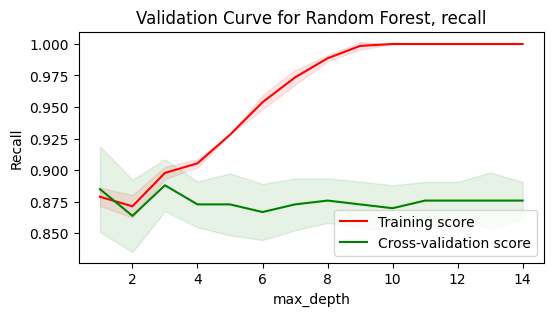

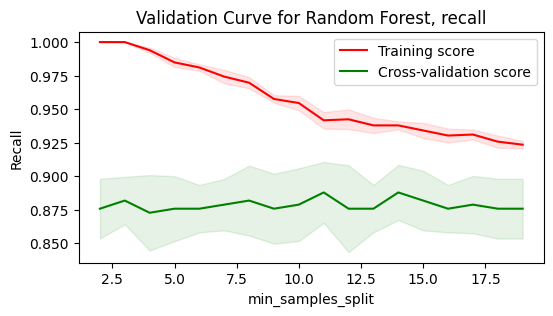

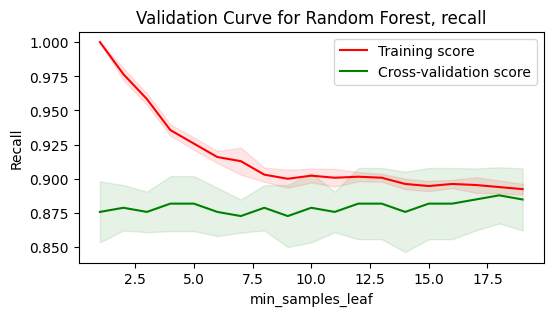

In [10]:
md_range = np.arange(1, 15)
plot_validation_curve('max_depth', md_range)

split_range = np.arange(1, 20)
plot_validation_curve('min_samples_split', split_range)

leaf_range = np.arange(1, 20)
plot_validation_curve('min_samples_leaf', leaf_range)

#### Max Depth
The training score starts low, but approaches 100% as `max_depth` exceeds 8. The cross validation scores remain relatively stable for all values, with a small peak at `max_depth=3`. This may suggest that our guess of `max_depth=10` might bee too high.

#### Minimum Split Samples
The training scores are, as expected, decreasing as `min_samples_split` increases, with a slight drop in decrease rate at `min_samples_split=11`. The cross validation scores are relatively stable, with a small local peak at `min_samples_split=11`. Our guess of `min_samples_split=10` might be a good choice.

### Minimum Leaf Samples
The training scores are decreasing rapidly until around `min_samples_leaf=6`, before stabilizing. The cross validation scores seems to be relatively stable. Thus the choice of `min_samples_leaf=1` does not appear to have a negative impact on the performance of the model. 

### Conclusion
Based on the validation curves, max_depth=10 may be too high as the best performance is seen at a lower depth, suggesting a shallower tree could effectively prevent overfitting. The setting of min_samples_split=10 is justified by the stable cross-validation scores, indicating it's a reasonable choice. The choice of min_samples_leaf=1, despite the rapid decline in training scores, does not adversely affect cross-validation scores, supporting its continued use. Overall, while adjustments could be explored, particularly in reducing max_depth, the initial settings appear largely appropriate.